# DQN Implementation for CartPole environment

## Import required libraries

In [1]:
!pip install gym

     ------------------------------------- 721.7/721.7 kB 11.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827650 sha256=94339364b82b7a777291060c42e692321a5958ceed24e7cf20ccb76d70f5c859
  Stored in directory: c:\users\hfydt1\appdata\local\pip\cache\wheels\af\2b\30\5e78b8b9599f2a2286a582b8da80594f654bf0e18d825a4405
Successfully built gym


In [2]:
import json
import random
import time
from collections import deque

import gym
import keras
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## Define DQNAgent Class

In [3]:
class DQNAgent:
    
    def __init__(self, state_size, action_size):

        self.state_size = state_size
        self.action_size = action_size
        
        # Initialize Replay Buffer as python deque
        self.replay_buffer = deque(maxlen=100000)
        
        # Set algorithm hyperparameters
        self.gamma = 0.99
        self.epsilon = 1.
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.98
        self.learning_rate = 0.1
        self.update_rate = 10
        
        # Create both Main and Target Networks
        self.main_network = self.create_nn()
        self.target_network = self.create_nn()
        
        # Initialize Target Network with Main Network's weights
        self.update_target_network()

    def create_nn(self):
        
        model = Sequential()

        model.add(Dense(64, activation='relu', input_dim=self.state_size))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))

        return model
    
    def update_target_network(self):
        # Method to set the Main NN's weights on the Target NN
        self.target_network.set_weights(self.main_network.get_weights())

    def save_experience(self, state, action, reward, next_state, terminal):
        
        # Save the given experience as a (s, a, r, s', terminal) tuple
        self.replay_buffer.append((state, action, reward, next_state, terminal))

    def sample_experience_batch(self, batch_size):
        
        # Sample {batchsize} experiences from the ReplayBuffer
        exp_batch = random.sample(self.replay_buffer, batch_size)

        # Create an array with the {batchsize} elements for s, a, r, s' and terminal information
        state_batch = np.array([batch[0] for batch in exp_batch]).reshape(batch_size, self.state_size)
        action_batch = np.array([batch[1] for batch in exp_batch])
        reward_batch = [batch[2] for batch in exp_batch]
        next_state_batch = np.array([batch[3] for batch in exp_batch]).reshape(batch_size, self.state_size)
        terminal_batch = [batch[4] for batch in exp_batch]

        # Return a tuple, where each item corresponds to each array/batch created above
        return state_batch, action_batch, reward_batch, next_state_batch, terminal_batch

    def pick_epsilon_greedy_action(self, state):

        # Pick random action with probability ε
        if random.uniform(0, 1) < self.epsilon:
            return np.random.randint(self.action_size)

        # Pick action with highest Q-Value (item with highest value for Main NN's output)
        state = state.reshape((1, self.state_size))
        q_values = self.main_network.predict(state, verbose=0)
        return np.argmax(q_values[0])

    def train(self, batch_size):

        # Sample a batch of experiences
        state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = self.sample_experience_batch(batch_size)

        # Get the actions with highest Q-Value for the batch of next states
        next_q = self.target_network.predict(next_state_batch, verbose=0)
        max_next_q = np.amax(next_q, axis=1)
        # Get the Q-values of each state in the batch of states
        q_values = self.main_network.predict(state_batch, verbose=0)

        # Update the Q-Value corresponding to the current action with the Target Value
        for i in range(batch_size):
            q_values[i][action_batch[i]] = reward_batch[i] if terminal_batch[i] else reward_batch[i] + self.gamma * max_next_q[i]

        # Fit the network
        self.main_network.fit(state_batch, q_values, verbose=0)


## Implement flow for DQN algorithm

### 1. Initialize Gym Environment

In [4]:
# Initialize CartPole environment
env = gym.make('CartPole-v1')

# Define state and action size
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

### 2. Define number of episodes, timesteps per episode and batch size

In [5]:
num_episodes = 100
num_timesteps = 350
batch_size = 64

### 3. Initlaize DQNAgent

In [6]:
dqn_agent = DQNAgent(state_size, action_size)

### 4. Implement and execute flow of DQN algorithm

In [7]:
rewards, epsilon_values, learning_rate_values = list(), list(), list() # Lists to keep logs of rewards and apsilon values, for plotting later
time_step = 0 # Initalize timestep counter

for ep in range(num_episodes):
    
    tot_reward = 0
    state, _ = env.reset()
    
    print(f'\nTraining on EPISODE {ep+1} with epsilon {dqn_agent.epsilon}')
    start = time.time()
    
    for t in range(num_timesteps):
        
        time_step += 1
        
        # Update Target Network every {dqn_agent.update_rate} timesteps
        if time_step % dqn_agent.update_rate == 0:
            dqn_agent.update_target_network()
            
        action = dqn_agent.pick_epsilon_greedy_action(state) # Select action with ε-greedy policy
        next_state, reward, terminal, _, _ = env.step(action) # Perform action on environment
        dqn_agent.save_experience(state, action, reward, next_state, terminal) # Save experience in ReplayBuffer

        state = next_state
        tot_reward += reward

        if terminal:
            print('Episode: ', ep+1, ' terminated with Reward ', tot_reward)
            break

        # Train the Main Network when ReplayBuffer has enough experiences to fill a batch
        if len(dqn_agent.replay_buffer) > batch_size:
            dqn_agent.train(batch_size)

    rewards.append(tot_reward)
    epsilon_values.append(dqn_agent.epsilon)
    
    # Everytime an episode is finished, update Epsilon value to a lower value
    if dqn_agent.epsilon > dqn_agent.epsilon_min:
        dqn_agent.epsilon *= dqn_agent.epsilon_decay
        
    # Print information about the Episode performed
    elapsed = time.time() - start
    print(f'Time elapsed during EPISODE {ep+1}: {elapsed} seconds = {round(elapsed/60, 3)} minutes')

    # If the agent got a reward >499 in each of the last 10 episodes, the training is terminated
    if sum(rewards[-10:]) > 4990:
        print('Training stopped because agent has performed a perfect episode in the last 10 episodes')
        break
        
        
        
        


Training on EPISODE 1 with epsilon 1.0
Episode:  1  terminated with Reward  10.0
Time elapsed during EPISODE 1: 0.0 seconds = 0.0 minutes

Training on EPISODE 2 with epsilon 0.98
Episode:  2  terminated with Reward  23.0
Time elapsed during EPISODE 2: 0.010402202606201172 seconds = 0.0 minutes

Training on EPISODE 3 with epsilon 0.9603999999999999
Episode:  3  terminated with Reward  36.0
Time elapsed during EPISODE 3: 0.8666763305664062 seconds = 0.014 minutes

Training on EPISODE 4 with epsilon 0.9411919999999999
Episode:  4  terminated with Reward  17.0
Time elapsed during EPISODE 4: 1.8210973739624023 seconds = 0.03 minutes

Training on EPISODE 5 with epsilon 0.9223681599999999
Episode:  5  terminated with Reward  39.0
Time elapsed during EPISODE 5: 4.370170593261719 seconds = 0.073 minutes

Training on EPISODE 6 with epsilon 0.9039207967999998
Episode:  6  terminated with Reward  24.0
Time elapsed during EPISODE 6: 2.7516443729400635 seconds = 0.046 minutes

Training on EPISODE 7

### 5. Test the trained by executing an episode

#### The test executes a complete episode without visualization, because of running in a JupyterNotebook. A test episode with visualization can be executed with the python script *dqn.py* available in the ArtificalIntelligence repository, in the DQN folder

In [8]:
def select_trained_agent_action(state, trained_model):
    q_values = trained_model.predict(state, verbose=0)
    return np.argmax(q_values[0])

In [9]:
env = gym.make('CartPole-v1', render_mode='human')
state, _ = env.reset()
state_size = env.observation_space.shape[0]
total_reward = 0
max_timesteps = 350

# Execute episode
for t in range(max_timesteps):
    print(f'Running frame {t+1}...', end='\r')
   
    state = state.reshape((1, state_size))
    action = select_trained_agent_action(state, dqn_agent.main_network)
    next_state, reward, terminal, _, _ = env.step(action)
   
    total_reward += reward
    state = next_state
   
env.close()
   
print(f'Test episode terminated with reward {total_reward} (Max Reward=350)')


C:\Anaconda3\lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


Test episode terminated with reward 69.0 (Max Reward=350)











































































### 6. Plot mean rewards of the agent 

In [10]:
import matplotlib.pyplot as plt

In [11]:
def plot_rewards(mean_range=1):
   
    # The parameter mean_range must allow equal separation of rewards
    if len(rewards) % mean_range != 0:
        raise ValueError
       
    # Calculate mean rewards
    mean_rewards = list()
    for i in range(round(len(rewards)/mean_range)):
        reward_on_range = rewards[i*mean_range:i*mean_range+mean_range]
        reward_on_range_mean = round(sum(reward_on_range)/len(reward_on_range))
        mean_rewards.append(reward_on_range_mean)
        
    average_reward = np.mean(rewards)
    print(f'Average reward for the entire training process:{average_reward}')

       
    plt.plot(range(len(mean_rewards)), mean_rewards, label='Mean Rewards')
    plt.axhline(y=average_reward, color='r', linestyle = '--', label='Average Reward')
    plt.legend()
    plt.xlabel('Episodes (in mean range)')
    plt.ylabel('Rewards')
    plt.title('Rewards vs Episodes')
    plt.show()

Average reward for the entire training process:78.01


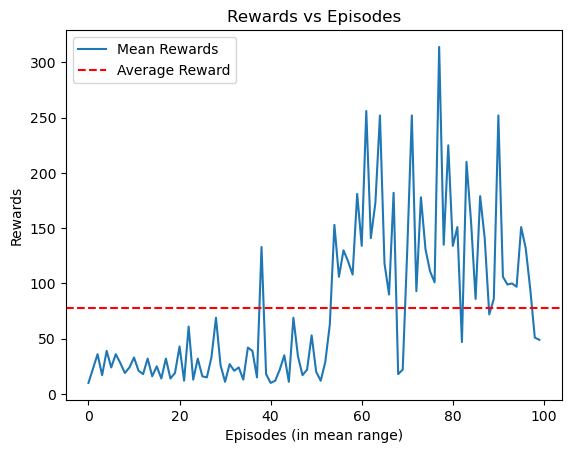

In [12]:
plot_rewards()

### 7. Plot values of moving average during the training

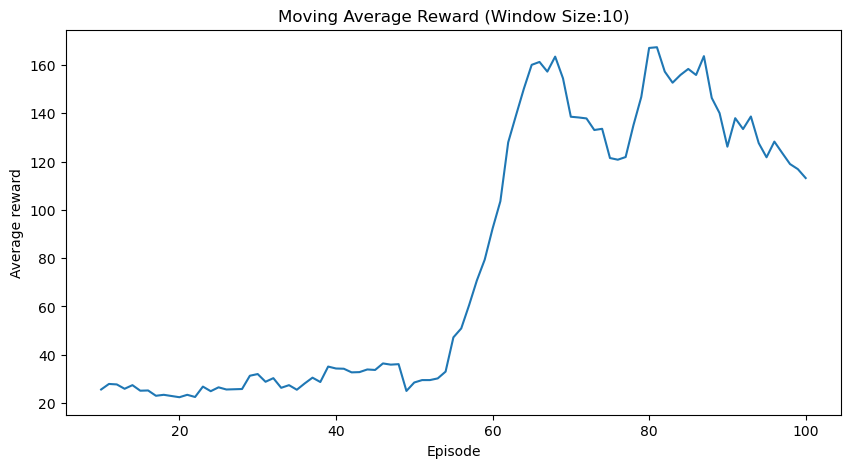

In [13]:
def moving_average(rewards, window_size):
    cum_sum = np.cumsum(np.insert(rewards,0,0))
    return (cum_sum[window_size:]-cum_sum[:-window_size]) / window_size

window_size = 10
avg_rewards = moving_average(rewards, window_size)

plt.figure(figsize=(10,5))
plt.plot(range(window_size, len(rewards)+1), avg_rewards)
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.title(f'Moving Average Reward (Window Size:{window_size})')
plt.show()   